In [16]:
########################################################################
#
# Example of 2D Bragg ptycho reconstruction from simulated data
# (c) ESRF 2017-present
# Authors: Vincent Favre-Nicolin <favre@esrf.fr>
#
########################################################################

import timeit
import sys
import numpy as np
from pynx.ptycho.bragg2d import *
from pynx.ptycho.bragg.cpu_operator import show_3d
from pynx.ptycho.simulation import spiral_archimedes
from pynx.wavefront import Wavefront, ImshowRGBA, ImshowAbs
import matplotlib.pyplot as plt
from pynx.processing_unit import default_processing_unit as main_default_processing_unit
from pynx.utils.math import smaller_primes

from silx.io.specfile import SpecFile
import fabio
from scipy.ndimage.measurements import center_of_mass
from ipywidgets import interact
# default_processing_unit.use_gpu()
%matplotlib inline

In [12]:
# Bragg ptycho parameters
specfile= "/mntdirect/_data_id01_inhouse/edo/hc3211/id01/spec/e17089/e17089.spec"
scan = 796
image_prefix= "/mntdirect/_data_id01_inhouse/edo/hc3211/id01/mpx/e17089/20171028ptycho/data_mpx4_%05d.edf.gz"

In [13]:
# Read spec scans
pixel_size_detector = 55e-6
s = SpecFile(specfile)['%d.1' % (scan)]
h = s.scan_header_dict
nrj = float(h['UMONO'].split('mononrj=')[1].split('ke')[0])
wavelength = 12.384 / nrj * 1e-10
print("Reading nrj from spec data: nrj=%6.3fkeV, wavelength=%6.3fA" % (nrj, wavelength*1e10))
detector_distance = float(h['UDETCALIB'].split('stance_CC=')[1].split(',')[0])
# detector_distance = 0.498
print("Detector distance: %6.3fm"% detector_distance)
eta = np.deg2rad(s.motor_position_by_name('eta'))
phi = np.deg2rad(s.motor_position_by_name('phi'))
delta = np.deg2rad(s.motor_position_by_name('del'))
nu = np.deg2rad(s.motor_position_by_name('nu'))
mpx4inr = s.data_column_by_name('mpx4inr').astype(np.int)
pix = s.data_column_by_name('pix')
piy = s.data_column_by_name('piy')
mpx4int = s.data_column_by_name('mpx4int')
if 'apdch1' in s.labels:
    apdch1 = s.data_column_by_name('apdch1')
filter = float(h['UFILT1'])

Reading nrj from spec data: nrj= 8.000keV, wavelength= 1.548A
Detector distance:  0.500m


In [14]:
# Load all images spiralscan
print('Loading images for scan:', scan)
iobs = None
ii = 0
t0= timeit.default_timer()
for i in mpx4inr:
    if (i - mpx4inr[0]) % 20 == 0:
        sys.stdout.write('%d ' % (i - mpx4inr[0]))
        sys.stdout.flush()
    frame = np.fliplr(fabio.open(image_prefix % i).data)
    if iobs is None:
        iobs = np.empty((len(mpx4inr), frame.shape[0], frame.shape[1]), dtype=frame.dtype)
    iobs[ii] = frame
    ii += 1
print("\n")
dt = timeit.default_timer() - t0
print('Time to read all frames: %4.1fs [%5.2f Mpixel/s]' % (dt, iobs.size / 1e6 / dt))

Loading images for scan: 796
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 

Time to read all frames: 14.5s [ 9.45 Mpixel/s]


In [17]:
@interact(i=(0,120))
def plot(i=0):
    plt.imshow(np.log(iobs[i]))

interactive(children=(IntSlider(value=0, description='i', max=120), Output()), _dom_classes=('widget-interact',))

In [19]:
# Create maxipix mask
ny, nx = iobs.shape[-2:]
mask = np.zeros((ny, nx), dtype=np.int8)
for i in range(258, ny, 258):
    mask[i - 3:i + 3] = 1
for i in range(258, nx, 258):
    mask[:, i - 3:i + 3] = 1
    
    
# Eiger mask

/users/zatterin/Envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


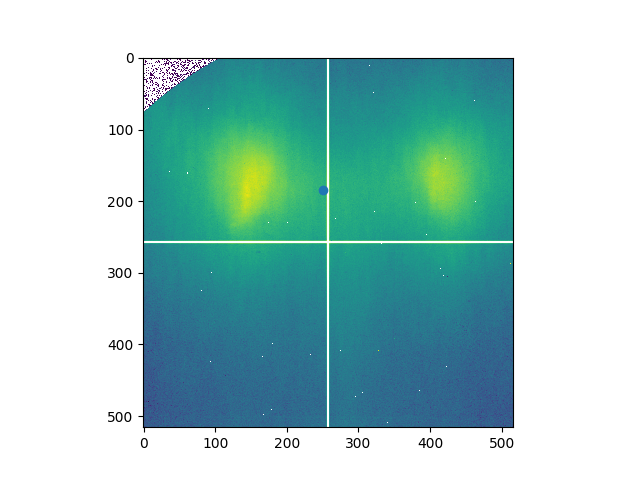

Center of mass: y0=184.4, x0=250.5


In [20]:
%matplotlib notebook
# Find center of diffraction
plt.imshow(np.log10(iobs.sum(axis=0)))
y0, x0 = center_of_mass(iobs.sum(axis=0))
print("Center of mass: y0=%5.1f, x0=%5.1f"%(y0,x0))
ny0, nx0 = iobs.shape[-2:]
ix0 = int(round(x0))
iy0 = int(round(y0))

if True:
    # Manually correct position
    #ix0 -= 35
    #iy0 += 15
    pass
plt.scatter([ix0],[iy0])  # To check visually

In [21]:
# Size of crop array
nx = 2 * min(ix0, nx0 - ix0)
ny = 2 * min(iy0, ny0 - iy0)

# Not too large - limts to half of det
# if nx > 256:
#     nx = 256
# if ny > 256:
#     ny = 256

# Manual crop

    
# Limit number of frames ?
if False:
    iobs=iobs[:48]
    pix = pix[:len(iobs)]
    piy = piy[:len(iobs)]

# crop to max fft size
ny, nx = smaller_primes((ny, nx), maxprime=default_processing_unit.max_prime_fft, required_dividers=(2,))

iobs = iobs[:, iy0-ny//2:iy0+ny//2,ix0-nx//2:ix0+nx//2]
mask = mask[iy0-ny//2:iy0+ny//2,ix0-nx//2:ix0+nx//2]
print(iobs.shape)

NameError: name 'default_processing_unit' is not defined

Text(0,0.5,'X (µm)')

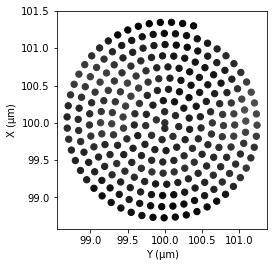

In [48]:
# Select area - too many frames !
#plt.plot(vs[ic]['pix'],iobsc.sum(axis=(1,2)))
v = iobs.sum(axis=(1,2))
%matplotlib inline
ax=plt.scatter(piy,pix,40,v/v.max(), vmin=0,vmax=1, cmap=plt.cm.Greys, edgecolors='face')
plt.gca().set_aspect(1)
plt.xlabel('Y (µm)')
plt.ylabel('X (µm)')

In [49]:
# Rotate positions according to eta
ce, se = np.cos(eta)*1e-6, np.sin(eta)*1e-6
xs = -pix * 1e-6
ys, zs = -se * piy, -ce * piy

# detector parameters
detector = {'geometry': 'psic', 'delta': delta, 'nu': nu, 'pixel_size': pixel_size_detector,
            'distance': detector_distance}

data = Bragg2DPtychoData(iobs=iobs, positions=(zs, ys, xs), mask=mask, wavelength=wavelength, detector=detector)

Probe pixel size:   9.51nm


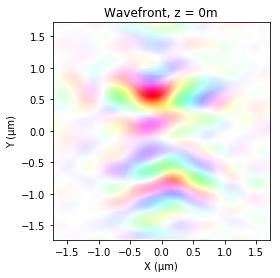

/users/zatterin/Envs/py3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


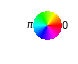

In [50]:
# Import existing probe from 2D ptycho
d = np.load("/data/id01/inhouse/edo/paul_ptycho/ResultsScan0031/latest.npz")
pr0 = d['probe'][0]
pr0 = np.fliplr(pr0)  # Needs flipping ?

pr = Wavefront(d=np.fft.fftshift(pr0,axes=(-2,-1)), z=0, pixel_size=d['pixelsize'], wavelength=wavelength)
print('Probe pixel size: %6.2fnm'%(pr.pixel_size*1e9))
%matplotlib inline
pr = ImshowRGBA()*pr

In [51]:
# Required until AP and DM are fixed
default_processing_unit.cl_stack_size = len(iobs)

In [52]:
# Create main Bragg Ptycho object
p = Bragg2DPtycho(probe=pr, data=data, support=None)
pxyz = p.voxel_size_object()
print(wavelength * detector_distance / (pixel_size_detector*nx)*1e9)
print("Object voxel size: %6.2fnm x %6.2fnm x %6.2fnm" % (pxyz[0] * 1e9, pxyz[1] * 1e9, pxyz[2] * 1e9))
print(p.m)

Calculating probe on object grid
Calculated probe shape:  229.35396652901542 256 256
Calculated object shape:  244 474 484
Initialised object with 244x474x484 voxels
12.246111078251614
Object voxel size:  15.80nm x  12.25nm x  12.25nm
[[-1.2243312e-08 -2.0292795e-10  2.1340915e-10]
 [ 0.0000000e+00  7.7374160e-09  1.2246111e-08]
 [-2.6180538e-10  9.4899129e-09 -9.9800657e-09]]


In [53]:
%matplotlib inline
# Create parallelepiped base object
x0, x1, y0, y1, z0, z1 = -5e-6, 5e-6, -50e-9, 50e-9, -5e-6, 5e-6,
x, y, z = p.get_xyz(domain='object', rotation=('x', eta))
obj0 = (x >= x0) * (x <= x1) * (y >= y0) * (y <= y1) * (z >= z0) * (z <= z1)

# Random amplitudes, phase to start ?
#p.set_obj(obj0 * np.random.uniform(0,1.0,obj0.shape))
p.set_obj(obj0)

# Identical support
rs = 1.1
x, y, z = p.get_xyz(domain='object', rotation=('x', eta))
sup = (x >= rs * x0) * (x <= rs * x1) * (y >= rs * y0) * (y <= rs * y1) * (z >= rs * z0) * (z <= rs * z1)
p.set_support(sup)

/users/zatterin/Envs/py3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


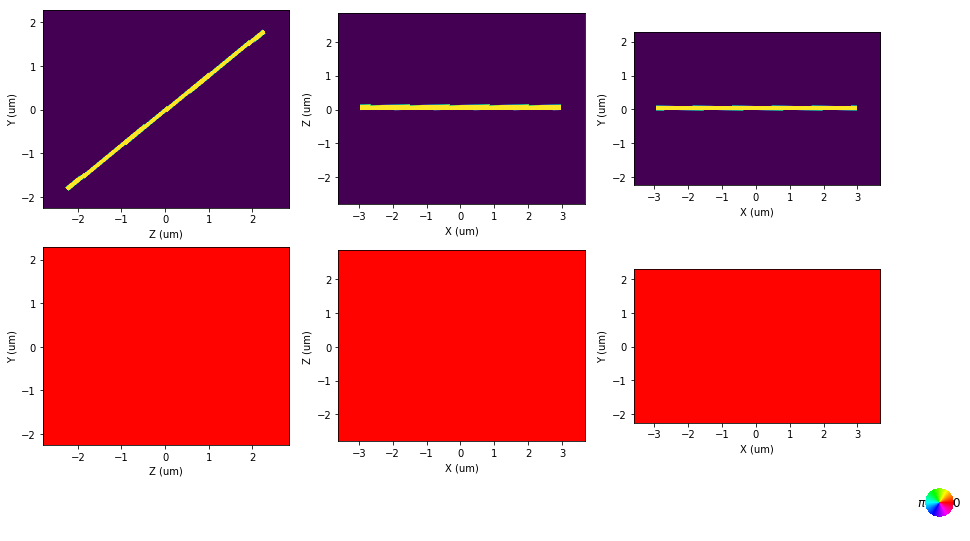

In [54]:
# Set object starting point
%matplotlib inline
p = ShowObj() * p

Searching available OpenCL GPU[ranking by fft, fft_shape=(16, 400, 400)]:
                          GeForce GTX 1060 6GB [NVIDIA CUDA]: 6072Mb [max alloc.: 1518Mb], 208.99 Gflop/s
                                  Quadro M2000 [NVIDIA CUDA]: 4037Mb [max alloc.: 1009Mb],  60.10 Gflop/s
Using OpenCL GPU: GeForce GTX 1060 6GB
Using OpenCL GPU: GeForce GTX 1060 6GB
Moving observed data to OpenCL GPU
Moving object, probe, mask, support to OpenCL GPU
  0: Chi2(Psi2D,Obj3D)=  140.892, reg=77449.332 (dt= 1.567s), gamma=   -0.000000
  1: Chi2(Psi2D,Obj3D)=  142.496, reg=54056.199 (dt= 1.149s), gamma=    0.000000
  2: Chi2(Psi2D,Obj3D)=  142.320, reg=17606.484 (dt= 1.148s), gamma=    0.000000
DM #  0 LLK=    55.82(p)  3440.50(g)    56.81(e), nb photons=1.674655e+08, dt/cycle=5.155s
  0: Chi2(Psi2D,Obj3D)=  363.282, reg=12394.939 (dt= 1.556s), gamma=   -0.000000
  1: Chi2(Psi2D,Obj3D)=  363.302, reg=11415.260 (dt= 1.149s), gamma=    0.000000
  2: Chi2(Psi2D,Obj3D)=  363.316, reg=5471.747 (dt= 1.1

  2: Chi2(Psi2D,Obj3D)= 52134.767, reg=3083.852 (dt= 1.150s), gamma=    0.000000
DM # 23 LLK=    54.45(p)  3451.54(g)    56.81(e), nb photons=1.677481e+08, dt/cycle=4.732s
  0: Chi2(Psi2D,Obj3D)= 56592.170, reg=3086.511 (dt= 1.557s), gamma=   -0.000000
  1: Chi2(Psi2D,Obj3D)= 56592.160, reg=3085.513 (dt= 1.150s), gamma=   -0.000000
  2: Chi2(Psi2D,Obj3D)= 56592.160, reg=3085.876 (dt= 1.149s), gamma=    0.000000
DM # 24 LLK=    54.45(p)  3451.51(g)    56.81(e), nb photons=1.677474e+08, dt/cycle=4.729s
  0: Chi2(Psi2D,Obj3D)= 61185.021, reg=3087.348 (dt= 1.558s), gamma=   -0.000000
  1: Chi2(Psi2D,Obj3D)= 61185.011, reg=3086.806 (dt= 1.150s), gamma=   -0.000000
  2: Chi2(Psi2D,Obj3D)= 61185.016, reg=3087.002 (dt= 1.150s), gamma=    0.000000
DM # 25 LLK=    54.45(p)  3451.49(g)    56.81(e), nb photons=1.677471e+08, dt/cycle=4.731s
  0: Chi2(Psi2D,Obj3D)= 66003.446, reg=3089.876 (dt= 1.557s), gamma=   -0.000000
  1: Chi2(Psi2D,Obj3D)= 66003.431, reg=3088.812 (dt= 1.151s), gamma=   -0.00000

/users/zatterin/Envs/py3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


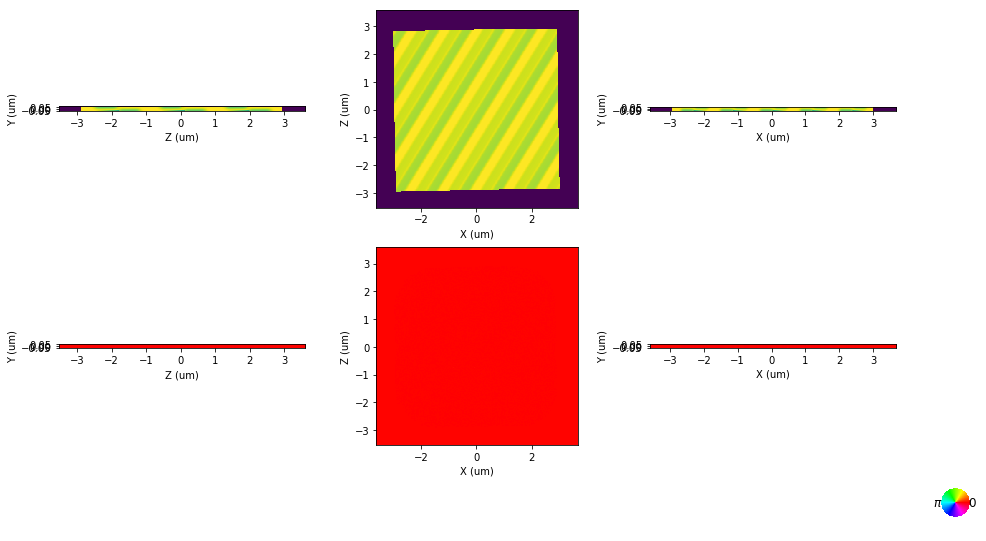

ML #  0 LLK=    54.41(p)  3450.92(g)    56.81(e), nb photons=1.677344e+08, dt/cycle=2.187s
ML #  1 LLK=    48.45(p)  3449.83(g)    56.60(e), nb photons=1.677237e+08, dt/cycle=2.191s
ML #  2 LLK=    42.33(p)  3445.15(g)    56.09(e), nb photons=1.676861e+08, dt/cycle=2.193s
ML #  3 LLK=    36.23(p)  3427.61(g)    55.00(e), nb photons=1.675666e+08, dt/cycle=2.192s
ML #  4 LLK=    30.35(p)  3370.31(g)    52.96(e), nb photons=1.672088e+08, dt/cycle=2.193s
ML #  5 LLK=    24.56(p)  3201.11(g)    49.32(e), nb photons=1.661968e+08, dt/cycle=2.194s
ML #  6 LLK=    18.98(p)  2789.57(g)    43.43(e), nb photons=1.636899e+08, dt/cycle=2.192s
ML #  7 LLK=    13.91(p)  2013.34(g)    34.96(e), nb photons=1.582592e+08, dt/cycle=2.193s
ML #  8 LLK=     9.46(p)  1007.49(g)    24.43(e), nb photons=1.477939e+08, dt/cycle=2.193s
ML #  9 LLK=     6.23(p)   333.43(g)    15.08(e), nb photons=1.319765e+08, dt/cycle=2.193s


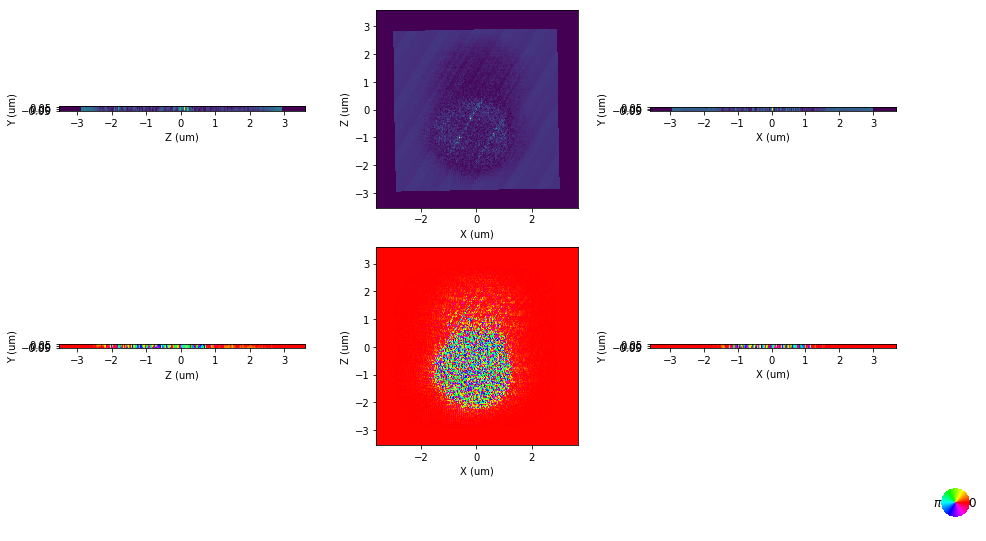

In [55]:
%matplotlib inline
# Solve !
p = DM(calc_llk=1,reg_fac_obj_c=100000) ** 40 * p
p = ShowObj(rotation=('x', eta)) * p
#p = AP(calc_llk=10, show_obj_probe=10) **100 * p
p = ML(calc_llk=1) ** 10 * p
# np.savez('/Users/favre/tmp/bragg.npz', probe3d=p._probe3d, obj=p.get_obj(), probe2d=pr.get(shift=True), x=x, y=y, z=z)
p = ShowObj(rotation=('x', eta)) * p

In [48]:
if False:
    # Try with object amplitude regularisation ?
    %matplotlib inline
    p = AP(calc_llk=1,reg_fac_obj_a=0.1) **40 * p

    %matplotlib inline
    p = ShowObj() * p

In [49]:
p=FreePU()*p
import gc
gc.collect()

Moving observed data to OpenCL GPU
Moving object, probe, mask, support to OpenCL GPU


35004

/users/zatterin/Envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


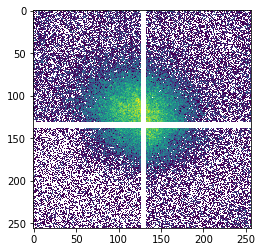

In [50]:
%matplotlib inline
plt.imshow(np.log10(iobs[30]))

/users/zatterin/Envs/py3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


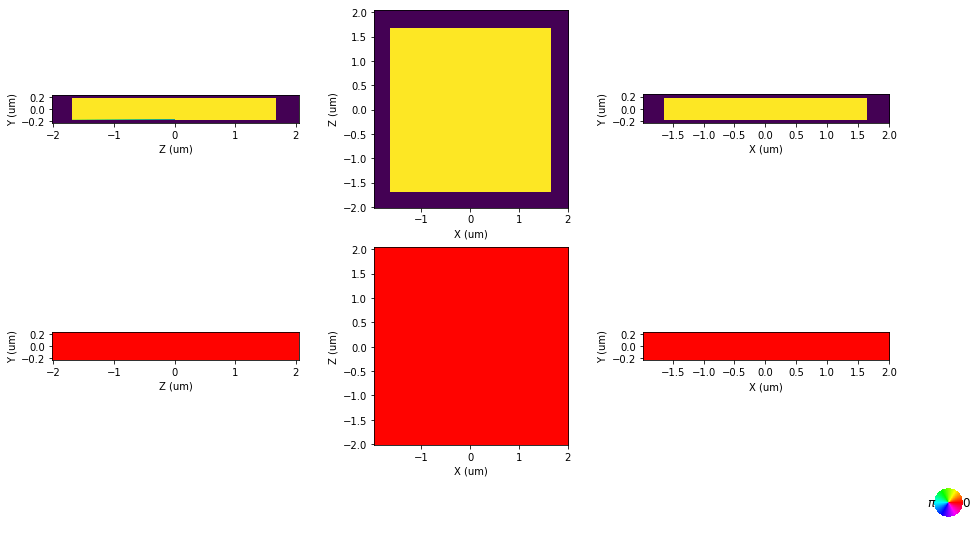

In [51]:
p = ShowObj(rotation=('x', eta)) * p

In [52]:
plt.figure(figsize=(8,8))
plt.imshow(np.log10(iobs[200]),origin='lower')

IndexError: index 200 is out of bounds for axis 0 with size 129